2.16.1
----------------------------------------
移动 C:\Users\10075\Downloads\Ai-Study\train\Abyssinian_100.jpg 到 C:\Users\10075\Downloads\Ai-Study\DataSet\train\cat\Abyssinian_100.jpg
移动 C:\Users\10075\Downloads\Ai-Study\train\Abyssinian_101.jpg 到 C:\Users\10075\Downloads\Ai-Study\DataSet\train\cat\Abyssinian_101.jpg
移动 C:\Users\10075\Downloads\Ai-Study\train\Abyssinian_102.jpg 到 C:\Users\10075\Downloads\Ai-Study\DataSet\train\cat\Abyssinian_102.jpg
移动 C:\Users\10075\Downloads\Ai-Study\train\Abyssinian_103.jpg 到 C:\Users\10075\Downloads\Ai-Study\DataSet\train\cat\Abyssinian_103.jpg
移动 C:\Users\10075\Downloads\Ai-Study\train\Abyssinian_104.jpg 到 C:\Users\10075\Downloads\Ai-Study\DataSet\train\cat\Abyssinian_104.jpg
移动 C:\Users\10075\Downloads\Ai-Study\train\Abyssinian_105.jpg 到 C:\Users\10075\Downloads\Ai-Study\DataSet\train\cat\Abyssinian_105.jpg
移动 C:\Users\10075\Downloads\Ai-Study\train\Abyssinian_106.jpg 到 C:\Users\10075\Downloads\Ai-Study\DataSet\train\cat\Abyssinian_106.jpg
移动 C:\U

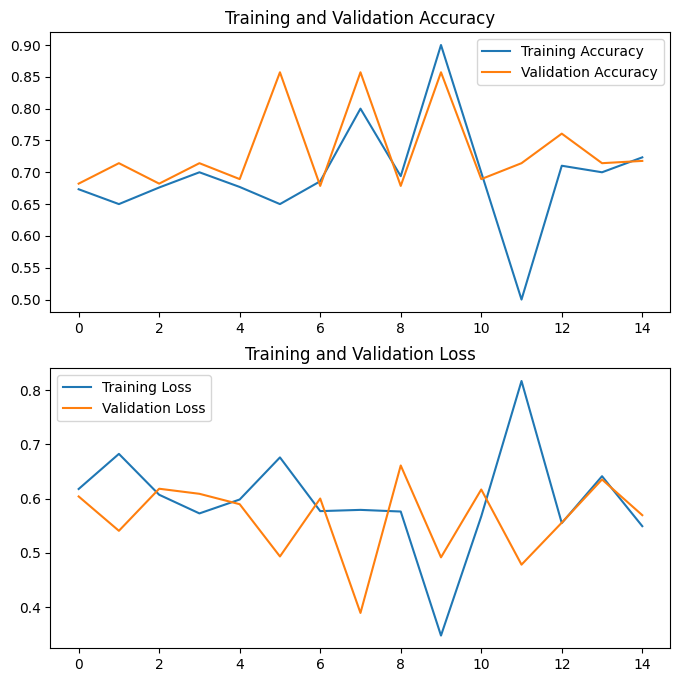

In [21]:
# -*- coding: utf-8 -*-

import os
import tensorflow as tf
import matplotlib.pyplot as plt  # 数据可视化
import pandas as pd  # 数据处理和分析
import numpy as np  # 科学计算
import shutil
import time # 测量代码段的执行时间
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# 目标 将得到的图片文件进行分类，分别将分拣出的图片放在对应的文件夹内
# 让模型进行猫狗图片的学习，并且将学习过程可视化
# 储存模型，来为后续的上传图片识别猫狗种类提供服务

# 打印TensorFlow版本，确保库已正确安装
print(tf.__version__)
print('----------------------------------------')



# 数据集路径
source_dir = r'C:\Users\10075\Downloads\Ai-Study\train'  # 源文件夹路径_原始图像文件夹路径。
target_dir = r'C:\Users\10075\Downloads\Ai-Study\DataSet'  # 目标文件夹路径_是目标文件夹路径，用于存储分类后的图片。
annotations_dir = r'C:\Users\10075\Downloads\Ai-Study\DataSet\annotations\annotations' # 是存储注释文件（如 list.txt）的文件夹路径。
list_path = os.path.join(annotations_dir, 'list.txt')

# 创建目标文件夹结构
for split in ['train', 'validation']:
    for category in ['cat', 'dog']:
        category_dir = os.path.join(target_dir, split, category)
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)

# 读取 list.txt 文件
with open(list_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        # 跳过注释行
        if line.startswith('#'):
            continue
        
        parts = line.strip().split()
        image_name = parts[0]
        class_id = int(parts[1])
        species = int(parts[2])  # 1:Cat 2:Dog
        breed_id = int(parts[3])

        if species == 1:
            category = 'cat'
        elif species == 2:
            category = 'dog'
        else:
            continue

        # 假设前80%为训练集，后20%为验证集
        split = 'train' if hash(image_name) % 10 < 8 else 'validation'

        src_path = os.path.join(source_dir, image_name + '.jpg')
        dest_path = os.path.join(target_dir, split, category, image_name + '.jpg')

        if not os.path.exists(src_path):
            print(f"文件 {src_path} 不存在，跳过。")
            continue

        shutil.move(src_path, dest_path)
        print(f"移动 {src_path} 到 {dest_path}")
print('----------')
print("分类完成")
print('----------')



# 设置数据路径
target_dir = r'C:\Users\10075\Downloads\Ai-Study\DataSet'
train_dir = os.path.join(target_dir, 'train')
validation_dir = os.path.join(target_dir, 'validation')

# 创建ImageDataGenerator实例，用于数据增强和归一化处理
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 划分20%数据作为验证集
)

# 加载训练和验证数据
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',  # 多分类
    subset='training'  # 训练数据
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',  # 多分类
    subset='validation'  # 验证数据
)

# 创建模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), # 第一个卷积层
    MaxPooling2D(2, 2),  # 第一个池化层
    Conv2D(64, (3, 3), activation='relu'), # 第二个卷积层
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'), # 第三个卷积层
    MaxPooling2D(2, 2),  # 第三个池化层
    Conv2D(128, (3, 3), activation='relu'), # 第四个卷积层
    MaxPooling2D(2, 2), # 第四个池化层
    Flatten(), # 展平层 
    Dense(512, activation='relu'), # 全连接层，512个神经元 
    Dense(train_generator.num_classes, activation='softmax')  #  输出层，根据类别数设置
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # 使用Adam优化器和分类交叉熵损失函数

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size, # 每轮迭代的步数 
    epochs=15, # 训练15轮
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size, # 验证集步数
    verbose=2 # 打印详细日志
)

# 保存模型
model.save('cat_dog_breed_classifier.h5')

# 可视化训练过程中的准确率和损失
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
# 训练准确率
plt.plot(acc, label='Training Accuracy')
# 验证准确率
plt.plot(val_acc, label='Validation Accuracy')
# 训练和验证准确率
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
# 训练损失
plt.plot(loss, label='Training Loss')
# 验证损失
plt.plot(val_loss, label='Validation Loss')
# 训练和验证损失
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

